# Exp: use GRU to do sentimental analysis on movie reviews

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import transforms
from torchtext.legacy import data
from torchtext.vocab import Vectors,GloVe

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import seaborn as sns
import time
import copy
import os

In [3]:
nltk.download()
nltk.download('stopwords')
nltk.download('punkt')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Error loading stopwords: <urlopen error [Errno 54]
[nltk_data]     Connection reset by peer>
[nltk_data] Error loading punkt: <urlopen error [Errno 54] Connection
[nltk_data]     reset by peer>


False

In [4]:
## define text data load func
def load_text_data(path):
    text_data = []
    label_list = []
    for label in ["pos","neg"]:
        path_set = os.path.join(path,label)
        path_list = os.listdir(path_set)
        # read data and label
        for fname in path_list:
            if fname.endswith(".txt"):
                filename = os.path.join(path_set,fname)
                with open(filename) as f:
                    text_data.append(f.read())
            if label == "pos":
                label_list.append(1)
            else:
                label_list.append(0)
    return np.array(text_data),np.array(label_list)

In [5]:
## read text data
train_path = "./data/MovieReviews/train"
test_path = "./data/MovieReviews/test"

train_text,train_label = load_text_data(train_path)
test_text,test_label = load_text_data(test_path)

In [6]:
train_text.shape

(25000,)

In [7]:
train_label.shape

(25000,)

In [8]:
## pre-process 1
import re
import string
def text_preprocess(text_data):
    text_pre = []
    for t in text_data:
        # rid of "<br /br><br /br>"
        t = re.sub("<br /br><br /br>"," ",t)
        # to lower case
        t = t.lower()
        t = re.sub("\d+","",t)
        # rid of punctuation
        t = t.translate(str.maketrans("","",string.punctuation.replace("'","")))
        # rid of redundent blank 
        t = t.strip()
        text_pre.append(t)
    return np.array(text_pre)
        
train_text_pre = text_preprocess(train_text)
test_text_pre = text_preprocess(test_text)

In [9]:
stop_words = []
with open("./data/MovieReviews/stopword.txt") as f:
    lines = f.readlines()
    for line in lines:
        stop_words.append(line.strip("\n"))
stop_words = set(stop_words)

In [10]:
## pre-process 2
def stop_stem_word(datalist,stop_words):
    datalist_pre = []
    for t in datalist:
        # t_w = word_tokenize(t)
        # rid of stop stem words
        # t_w = [w for w in t if not w in stop_words]
        # rid of "'"
        t_w = [w for w in t.split() if len(re.findall("'",w)) == 0]
        datalist_pre.append(t_w)
        # if len(re.findall("'",t)) == 0:
        #   datalist_pre.append(t)
    return np.array(datalist_pre)

train_text_pre_2 = stop_stem_word(train_text_pre,stop_words)
test_text_pre_2 = stop_stem_word(test_text_pre,stop_words)

/opt/anaconda3/envs/python3-7/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [11]:
print(train_text_pre[100])

sure it was cheesy and nonsensical and at times corny but at least the filmmakers didn't try while most tv movies border on the brink of mediocrity this film actually has some redeeming qualities to it the cinematography was pretty good for a tv film and viggo mortensen displays shades of aragorn in a film about a man who played by his own rules most of the flashback sequences were kind of cheesy but the scene with the mountain lion was intense i was kind of annoyed by jason priestly's role in the film as a rebellious shockjock but then again it's a tv movie despite all of the good things the soundtrack was atrocious however it was nice to see tucson arizona prominently featured in the film


In [12]:
print(train_text_pre_2[100])

['sure', 'it', 'was', 'cheesy', 'and', 'nonsensical', 'and', 'at', 'times', 'corny', 'but', 'at', 'least', 'the', 'filmmakers', 'try', 'while', 'most', 'tv', 'movies', 'border', 'on', 'the', 'brink', 'of', 'mediocrity', 'this', 'film', 'actually', 'has', 'some', 'redeeming', 'qualities', 'to', 'it', 'the', 'cinematography', 'was', 'pretty', 'good', 'for', 'a', 'tv', 'film', 'and', 'viggo', 'mortensen', 'displays', 'shades', 'of', 'aragorn', 'in', 'a', 'film', 'about', 'a', 'man', 'who', 'played', 'by', 'his', 'own', 'rules', 'most', 'of', 'the', 'flashback', 'sequences', 'were', 'kind', 'of', 'cheesy', 'but', 'the', 'scene', 'with', 'the', 'mountain', 'lion', 'was', 'intense', 'i', 'was', 'kind', 'of', 'annoyed', 'by', 'jason', 'role', 'in', 'the', 'film', 'as', 'a', 'rebellious', 'shockjock', 'but', 'then', 'again', 'a', 'tv', 'movie', 'despite', 'all', 'of', 'the', 'good', 'things', 'the', 'soundtrack', 'was', 'atrocious', 'however', 'it', 'was', 'nice', 'to', 'see', 'tucson', 'arizo

In [13]:
## save the pre-processed text data
texts = [" ".join(words) for words in train_text_pre_2]
train_data_df = pd.DataFrame({'text':texts,'label':train_label})
texts = [" ".join(words) for words in test_text_pre_2]
test_data_df = pd.DataFrame({'text':texts,'label':test_label})

train_data_df.to_csv("./data/MovieReviews/cleaned/train.csv",index=False)
test_data_df.to_csv("./data/MovieReviews/cleaned/test.csv",index=False)

Text(0, 0.5, 'freq')

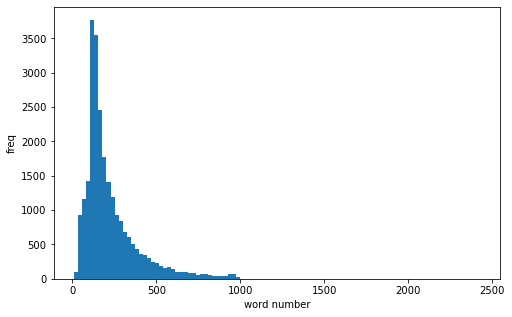

In [14]:
## plot the distribution of words' length
train_word_num = [len(text) for text in train_text_pre_2]
plt.figure(figsize=(8,5))
plt.hist(train_word_num,bins = 100)
plt.xlabel("word number")
plt.ylabel("freq")

In [15]:
closure = lambda x:x.split()

TEXT = data.Field(
    sequential=True,
    tokenize = closure,
    include_lengths = True,use_vocab = True,
    batch_first = True,fix_length = 200
)
LABEL = data.Field(
    sequential= False,
    use_vocab = False,
    pad_token = None,unk_token = None
)

In [16]:
## read from cleaned data
train_test_fields = [
     ("text",TEXT),
     ("label",LABEL),
]

traindata,testdata = data.TabularDataset.splits(
    path = "./data/MovieReviews/cleaned",format="csv",
    train="train.csv",fields = train_test_fields,
    test="test.csv",skip_header = True,
)
len(traindata),len(testdata)

(25000, 25000)

In [17]:
## print an example
ex0 = traindata.examples[1110]
print(ex0.label)
print(ex0.text)

1
['stories', 'of', 'the', 'century', 'was', 'a', 'half', 'hour', 'series', 'and', 'appeared', 'in', 'first', 'run', 'syndication', 'during', 'the', 'television', 'season', 'it', 'was', 'also', 'the', 'first', 'western', 'tv', 'series', 'to', 'win', 'an', 'emmy', 'award', 'starring', 'veteran', 'western', 'actor', 'jim', 'davis', 'as', 'railroad', 'detective', 'matt', 'clark', 'the', 'series', 'set', 'clark', 'and', 'his', 'fellow', 'railroad', 'detective', 'partners', 'mary', 'castle', 'as', 'frankie', 'adams', 'for', 'the', 'first', 'half', 'of', 'the', 'season', 'and', 'kristine', 'miller', 'as', 'jonesy', 'during', 'the', 'second', 'halfagainst', 'historic', 'western', 'outlaws', 'of', 'various', 'periods', 'ranging', 'from', 'the', 'to', 'the', 'early', 'the', 'series', 'was', 'very', 'satisfying', 'easy', 'to', 'watch', 'and', 'fairly', 'realistic', 'due', 'mainly', 'to', 'the', 'easygoing', 'charm', 'of', 'jim', 'davis', 'in', 'the', 'lead', 'role', 'he', 'seemed', 'like', 'an',

In [18]:
train_data,val_data = traindata.split(split_ratio=0.7)
test_data = testdata
len(train_data),len(val_data),len(test_data)

(17500, 7500, 25000)

In [19]:
## get words vector
vec = Vectors("glove.6B.100d.txt","./data/MovieReviews")
TEXT.build_vocab(train_data,max_size=20000,vectors=vec)
LABEL.build_vocab(train_data)

In [20]:
## get examples from vocab
print(TEXT.vocab.freqs.most_common(n=10))
print("num of vocab: ",len(TEXT.vocab.itos))
print("top 10 vocab: ",TEXT.vocab.itos[0:10])
print("labels freq: ",LABEL.vocab.freqs)

[('the', 235215), ('and', 114184), ('a', 113852), ('of', 101757), ('to', 94920), ('is', 75105), ('in', 65642), ('it', 54230), ('i', 53366), ('this', 52655)]
num of vocab:  20002
top 10 vocab:  ['<unk>', '<pad>', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']
labels freq:  Counter({'1': 8792, '0': 8708})


In [21]:
## define iterator
BATCH_SIZE = 32
train_iter = data.BucketIterator(train_data,batch_size=BATCH_SIZE)
val_iter = data.BucketIterator(val_data,batch_size=BATCH_SIZE)
test_iter = data.BucketIterator(test_data,batch_size=BATCH_SIZE)

In [22]:
## create GRU net
class GRUNet(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,layer_dim,output_dim):
        super(GRUNet,self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # vocab process
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        # GRU
        self.gru = nn.GRU(embedding_dim,hidden_dim,layer_dim,batch_first=True)
        # full connection
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim,hidden_dim),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU(),
            nn.Linear(hidden_dim,output_dim)
        )
    
    def forward(self,x):
        embeds = self.embedding(x)
        # r_out: [batch,time_step,output_size]
        # h_n: [n_layers,batch,hidden_size]
        r_out,h_n = self.gru(embeds,None)
        output = self.fc(r_out[:,-1,:]) # put in the latest r_out
        return output

In [23]:
## init net
vocab_size = len(TEXT.vocab)
embedding_dim = vec.dim
hidden_dim = 128
layer_dim = 1
output_dim = 2

gruNet = GRUNet(vocab_size,embedding_dim,hidden_dim,layer_dim,output_dim)
gruNet

GRUNet(
  (embedding): Embedding(20002, 100)
  (gru): GRU(100, 128, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [24]:
## copy vocab
gruNet.embedding.weight.data.copy_(TEXT.vocab.vectors)
# unk and pad's weight to zero
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
gruNet.embedding.weight.data[UNK_IDX] = torch.zeros(vec.dim)
gruNet.embedding.weight.data[PAD_IDX] = torch.zeros(vec.dim)

In [25]:
## train
def train(model,train_loader,test_loader,loss_func,optimizer,num_epochs=25):
    train_loss_all = []
    train_acc_all = []
    test_loss_all = []
    test_acc_all = []
    learn_rate = []
    sinc = time.time()
    scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma = 0.1)
    
    for epoch in range(num_epochs):
        learn_rate.append(scheduler.get_last_lr()[0])
        print('-',10)
        print('Epoch {}/{}'.format(epoch+1,num_epochs,learn_rate[-1]))
        # train mode
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        model.train()
        for step,batch in enumerate(train_loader):
            text,target = batch.text[0],batch.label
            output = model(text)
            pre_lab = torch.argmax(output,1)
            loss = loss_func(output,target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(target)
            train_corrects += torch.sum(pre_lab == target.data)
            train_num += len(target)
        # get train loss and acc
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        print('train loss: {:.4f} train acc: {:.4f}'.format(train_loss_all[-1],train_acc_all[-1]))
        scheduler.step() # update learning rate
        # test mode
        test_loss = 0.0
        test_corrects = 0
        test_num = 0
        model.eval()
        for step,batch in enumerate(test_loader):
            text,target = batch.text[0],batch.label
            output = model(text)
            pre_lab = torch.argmax(output,1)
            loss = loss_func(output,target)
            
            test_loss += loss.item() * len(target)
            test_corrects += torch.sum(pre_lab == target.data)
            test_num += len(target)
         # get test loss and acc
        test_loss_all.append(test_loss / test_num)
        test_acc_all.append(test_corrects.double().item() / test_num)
        print('test loss: {:.4f} test acc: {:.4f}'.format(test_loss_all[-1],test_acc_all[-1]))   
    
    train_process = pd.DataFrame(
        data = {
            "epoch":range(num_epochs),
            "train_loss_all":train_loss_all,
            "train_acc_all":train_acc_all,
            "test_loss_all":test_loss_all,
            "test_acc_all":test_acc_all,
            "learn_rate":learn_rate
        }
    )
    return model,train_process

In [26]:
## define optimizer and loss func
optimizer = optim.RMSprop(gruNet.parameters(),lr = 0.003)
loss_func = nn.CrossEntropyLoss()

In [27]:
## training
gruNet,train_process = train(gruNet,train_iter,test_iter,loss_func,optimizer,10)

- 10
Epoch 1/10
train loss: 0.7020 train acc: 0.4975
test loss: 0.6931 test acc: 0.5000
- 10
Epoch 2/10
train loss: 0.5318 train acc: 0.7002
test loss: 0.3297 test acc: 0.8599
- 10
Epoch 3/10
train loss: 0.2380 train acc: 0.9087
test loss: 0.3573 test acc: 0.8629
- 10
Epoch 4/10
train loss: 0.1121 train acc: 0.9602
test loss: 0.5223 test acc: 0.8456
- 10
Epoch 5/10
train loss: 0.0370 train acc: 0.9881
test loss: 0.8680 test acc: 0.8390
- 10
Epoch 6/10
train loss: 0.0065 train acc: 0.9981
test loss: 1.1070 test acc: 0.8389
- 10
Epoch 7/10
train loss: 0.0020 train acc: 0.9996
test loss: 1.4500 test acc: 0.8348
- 10
Epoch 8/10
train loss: 0.0012 train acc: 0.9999
test loss: 1.6752 test acc: 0.8337
- 10
Epoch 9/10
train loss: 0.0004 train acc: 0.9999
test loss: 1.9736 test acc: 0.8360
- 10
Epoch 10/10
train loss: 0.0004 train acc: 0.9999
test loss: 2.3178 test acc: 0.8353


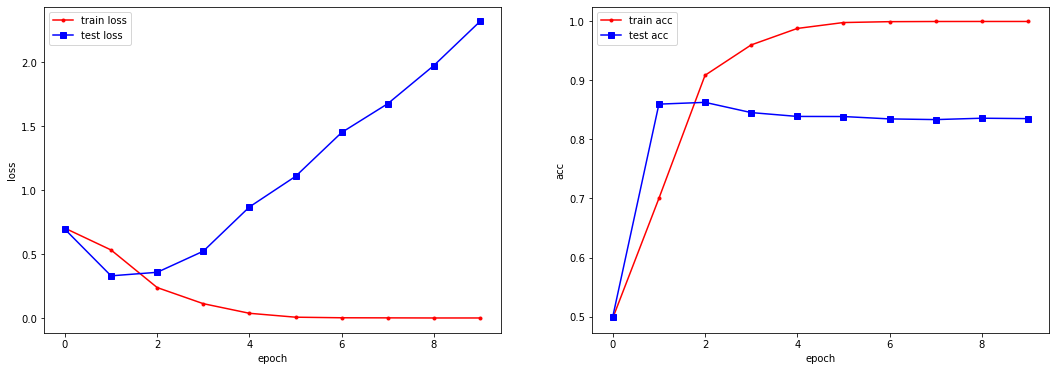

In [28]:
## show the process
plt.figure(figsize=(18,6))
# loss
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,"r.-",label = "train loss")
plt.plot(train_process.epoch,train_process.test_loss_all,"bs-",label = "test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
# acc
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,"r.-",label = "train acc")
plt.plot(train_process.epoch,train_process.test_acc_all,"bs-",label = "test acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")

plt.show()